In [131]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [132]:
%matplotlib inline

In [ ]:
df_links = pd.read_csv('data/ml-latest-small/links.csv')
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

df_links, df_movies, df_ratings

In [201]:
df_tags = pd.read_csv('data/ml-latest-small/tags.csv')

tags = np.unique(list(map(lambda x: x.lower(), df_tags.iloc[:, 2].tolist()))).tolist()
tag_vocab = {tag: i for i, tag in enumerate(tags)}
tag_itos = {i: tag for tag, i in tag_vocab.items()}

print("unique tags:", len(tags))

df_tags.head()

unique tags: 1475


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [166]:
for genre_str in df_movies['genres']:
    movie_genres = genre_str.split('|')
    for g in [x.lower().replace(' ', '_') for x in movie_genres]:
        if g not in df_movies.columns:
            df_movies.insert(loc=len(df_movies.columns), column=g, value=0)

for i in range(0, len(df_movies)):
    for g in [x.lower().replace(' ', '_') for x in df_movies['genres'][i].split('|')]:
        df_movies.at[i, g] = 1

df_movies = df_movies.drop(columns=['(no_genres_listed)'])
df_movies.head()

,movieId,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [168]:
class MovielensDataset(Dataset):
    def __init__(self, df_ratings, df_movies):
        self.df_ratings = df_ratings
        self.df_movies = df_movies

    def __len__(self):
        return len(self.df_ratings)
    
    def __getitem__(self, idx):        
        user_id = self.df_ratings.iloc[idx, 0]
        movie_id = self.df_ratings.iloc[idx, 1] 
        rating = self.df_ratings.iloc[idx, 2]
        
        return user_id, movie_id, float(rating)
    
movielens_dataset = MovielensDataset(df_ratings, df_movies)

# Classic matrix factorization

In [174]:
class MatrixFactorizationModel(torch.nn.Module):
    def __init__(self, num_users, num_movies, num_factors):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(num_users, num_factors)
        self.movie_embeddings = torch.nn.Embedding(num_movies, num_factors)
        self.linear = torch.nn.Linear(num_factors * 2, out_features=1)

    def forward(self, user_id, movie_id):
        user_embedding = self.user_embeddings(user_id) # (batch_size, num_factors)
        movie_embedding = self.movie_embeddings(movie_id) # (batch_size, num_factors)
        x = torch.cat([user_embedding, movie_embedding], dim=1) # (batch_size, 2 * num_factors)
        x = self.linear(x)
        return res

In [175]:
split = int(len(movielens_dataset) * 0.8)
train_data, valid_data = torch.utils.data.random_split(movielens_dataset, [split, len(movielens_dataset) - split], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=256, shuffle=True, num_workers=0)

In [176]:
n_users = df_ratings['userId'].max() + 1
n_movies = df_ratings['movieId'].max() + 1
model = MatrixFactorizationModel(n_users, n_movies, 10)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    losses = []
    for i, batch in enumerate(train_loader):
        model.train()
        user_ids, movie_ids, ratings = batch
        y_hat = model(user_ids, movie_ids).squeeze()
        loss = F.mse_loss(y_hat, ratings.float())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

@torch.no_grad()
def validate():
    losses = []
    for i, batch in enumerate(valid_loader):
        model.eval()
        user_ids, movie_ids, ratings = batch
        y_hat = model(user_ids, movie_ids).squeeze()
        loss = F.mse_loss(y_hat, ratings.float())
        losses.append(loss.item())

    return np.mean(losses)

for e in range(3):
    train_loss = train()
    valid_loss = validate()
    print(f'Epoch {e}, train loss: {train_loss}, valid loss: {valid_loss}')

Epoch 0, train loss: 22.72480891022501, valid loss: 22.151894146883034
Epoch 1, train loss: 21.10675249824041, valid loss: 21.001735228526442
Epoch 2, train loss: 19.748554371580294, valid loss: 20.037580828123456


In [118]:
valid_loss = validate()
print(f'Final validation loss: {valid_loss}')

Final validation loss: 0.8623339941230002


In [119]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [122]:
model(torch.tensor([1]), torch.tensor([3]))

tensor([[4.2872]], grad_fn=<AddmmBackward0>)

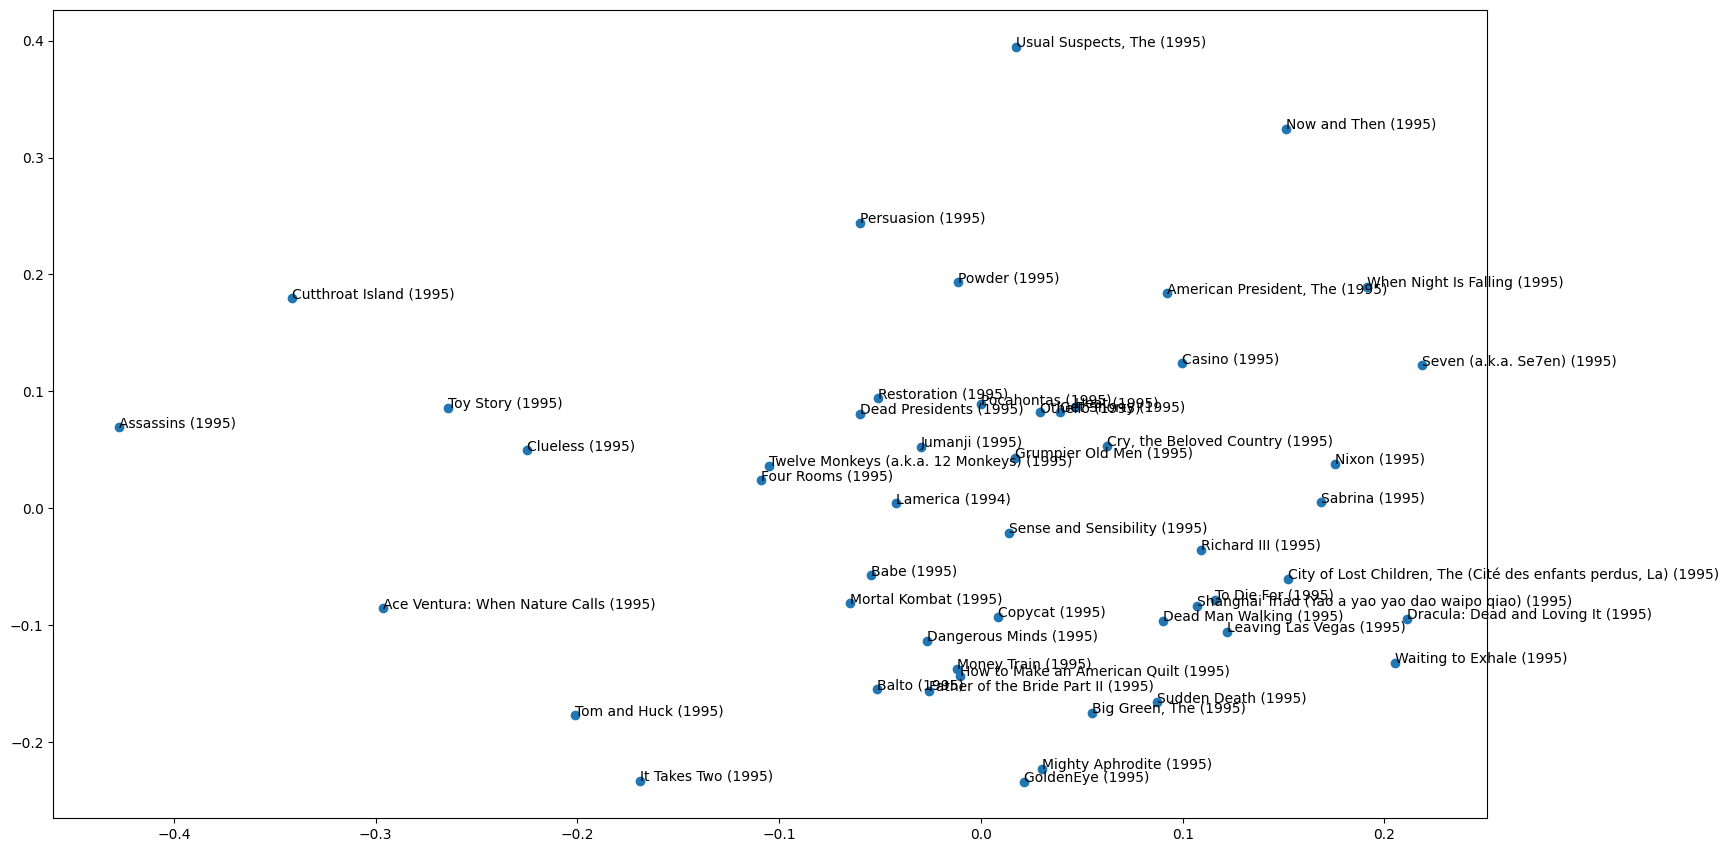

In [173]:
movies = df_movies[:50]['movieId'].tolist()
titles = df_movies[:50]['title'].tolist()

movie_embeddings = model.movie_embeddings(torch.tensor(movies)).detach()
t = torch.pca_lowrank(movie_embeddings, q=2)

X = t[0][:, 0]
Y = t[0][:, 1]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(X, Y)

for i, title in enumerate(titles):
    ax.annotate(title, (X[i], Y[i]))
#len(t), t[0].shape, t[1].shape

# Concatenating features and embeddings

Building on the model from https://arxiv.org/abs/1606.07792, now using other features such as category.

<img src="wide_n_deep.png" height="400">

In [178]:
df_movies.head()

,movieId,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
class MovielensCategoriesDataset(Dataset):
    def __init__(self, df_ratings, df_movies, df_tags):
        self.df_ratings = df_ratings
        self.df_movies = df_movies
       # self.df_tags = df_tags

    def __len__(self):
        return len(self.df_ratings)
    
    def __getitem__(self, idx):        
        user_id = self.df_ratings.iloc[idx, 0]
        movie_id = self.df_ratings.iloc[idx, 1] 
        rating = self.df_ratings.iloc[idx, 2]
        categories = self.df_movies.loc[self.df_movies['movieId'] == movie_id].iloc[:, 3:].values
        categories = torch.tensor(categories[0].tolist())        
        return user_id, movie_id, float(rating), categories #, tags
    
categories_dataset = MovielensCategoriesDataset(df_ratings, df_movies, df_tags)
categories_dataset[0]

(1, 1, 4.0, tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [239]:
class MovielensModelV2(torch.nn.Module):
    def __init__(self, num_users, num_movies, num_factors, num_categories):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(num_users, num_factors)
        self.movie_embeddings = torch.nn.Embedding(num_movies, num_factors)
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(num_factors * 2 + num_categories, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, out_features=1)
        ])

    def forward(self, user_id, movie_id, categories):
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_id)
        
        x = torch.cat([user_embedding, movie_embedding, categories], dim=1)

        for layer in self.layers:
            x = layer(x)

        return x

In [240]:
torch.Generator().manual_seed(42)

split = int(len(categories_dataset) * 0.8)
train_data, valid_data = torch.utils.data.random_split(categories_dataset, [split, len(movielens_dataset) - split])
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=256, shuffle=True, num_workers=0)

n_users = df_ratings['userId'].max() + 1
n_movies = df_ratings['movieId'].max() + 1
model = MovielensModelV2(n_users, n_movies, 10, 19)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train():
    losses = []
    for batch in train_loader:
        model.train()
        user_ids, movie_ids, ratings, categories = batch
        y_hat = model(user_ids, movie_ids, categories).squeeze()
        loss = F.mse_loss(y_hat, ratings.float())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

@torch.no_grad()
def validate():
    losses = []
    for batch in valid_loader:
        model.eval()
        user_ids, movie_ids, ratings, categories = batch
        y_hat = model(user_ids, movie_ids).squeeze()
        loss = F.mse_loss(y_hat, ratings.float())
        losses.append(loss.item())

    return np.mean(losses)

for e in range(3):
    train_loss = train()
    valid_loss = validate()
    print(f'Epoch {e}, train loss: {train_loss}, valid loss: {valid_loss}')

KeyboardInterrupt: 